Hazard Emulator
===============

Given a database of hazard events, the module `climada.hazard.emulator` provides tools to subsample events (or time series of events) from that event database. The module provides functionality to guard the subsampling, e.g., using bias-corrected statistics according to historical records in a specific georegion, or using calibrated statistics according to a climate scenario.

In more complex cases, the given event database is divided into a (smaller) set of observed hazard events and a (much larger) set of simulated hazard events. The database of observed events is used to statistically fit the frequency and intensity of events in a fixed georegion to (observed) climate indices. Then, given a hypothetical (future) time series of these climate indices (a "climate scenario"), a "hazard emulator" can draw random samples from the larger database of simulated hazard events that mimic the expected occurrence of events under the given climate scenario in the specified georegion.

The concept and algorithm as applied to tropical cyclones is originally due to Tobias Geiger (unpublished as of now) and has been generalized within this package by Thomas Vogt.

This notebook illustrates the functionality through the example of tropical cyclones in the eastern pacific under the RCP 2.6 climate scenario according to the MIROC5 global circulation model (GCM). However, the algorithm can be applied to arbitrary Hazard types given a suitable database of synthetic events.

### Load hazard data

The database of hazard events for this tutorial is too large to be provided with it. Instructions on how to obtain or generate the data are provided in the last section of this tutorial. At this point, we load a precomputed `Hazard` object from a file that contains simulated tropical cyclone tracks for an RCP 2.6 climate scenario according to MIROC5. Note, however, that this module will work with any `Hazard` object, preferably containing a lot of events.

In [1]:
import os
from climada.util.constants import DATA_DIR
EMULATOR_DATA_DIR = os.path.join(DATA_DIR, "emulator")

2020-12-16 14:33:54,479 - climada - DEBUG - Loading default config file: /home/tovogt/code/climada_python/climada/conf/defaults.conf


In [2]:
from climada.hazard import TropCyclone
hazard = TropCyclone()
hazard.read_hdf5(os.path.join(EMULATOR_DATA_DIR, "hazard_360as_miroc_rcp26.hdf5"))

2020-12-16 14:33:55,930 - climada.hazard.base - INFO - Reading /home/tovogt/code/climada_python/data/emulator/hazard_360as_miroc_rcp26.hdf5


We quickly try to give an impression of what this particular `Hazard` object looks like. It contains `hazard.size = 45300` tropical cyclone wind fields that are computed on a global set of centroids with 360 arc-seconds (0.1 degree) resolution onland and 1 degree resolution offshore. The physical effects onland are considered more important, the low-resolution information offshore is mostly relevant for plotting purposes:

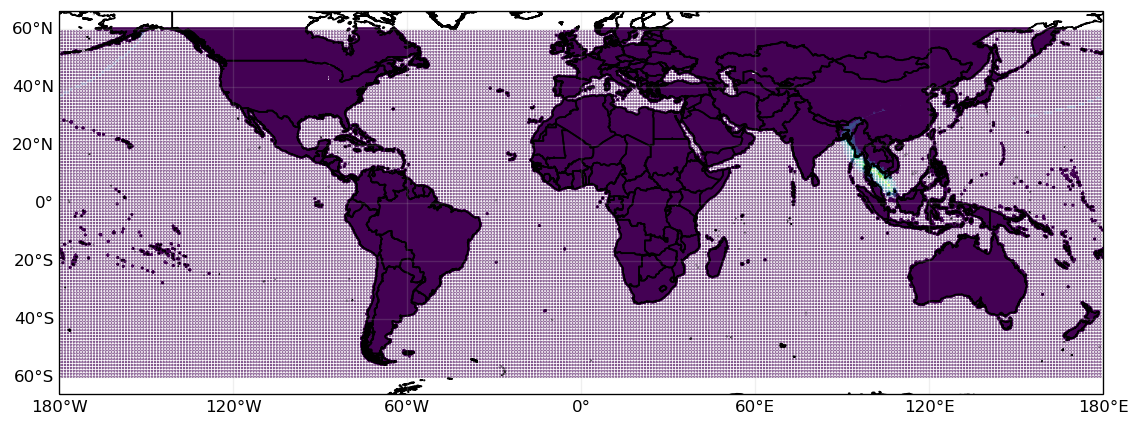

In [3]:
import warnings; warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
hazard.centroids.plot(c=hazard.intensity[16637,:].toarray().ravel(), s=0.1)

### Define the region of interest
One basic feature of the `climada.hazard.emulator` module is the `HazRegion` class that not only defines the geographical region of interest for the statistics, but might also contain climatic information about the selected region, such as the cyclone (hurricane) season. For tropical cyclone hazards there already exists a derived class `TCRegion` that defines ocean basins and cyclone seasons.


The cyclone season in basin EP spans from month 7 until month 12.



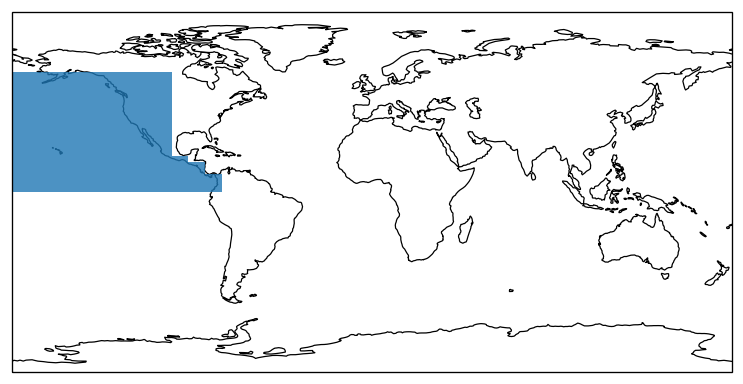

In [4]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from climada.hazard.emulator.geo import TCRegion
# load Eastern Pacific basin, print season (months of year) and plot geometry
region = TCRegion(tc_basin="EP")
print(f"\nThe cyclone season in basin {region.tc_basin} spans "
      f"from month {region.season[0]} until month {region.season[1]}.\n")

ax = plt.gcf().add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('110m'), linewidth=0.75)
ax.add_geometries([region.shape], crs=ccrs.PlateCarree(), alpha=0.8)

For our analysis, we restrict to the hazard events that affect the land area (defined by the `on_land` property) in this region:

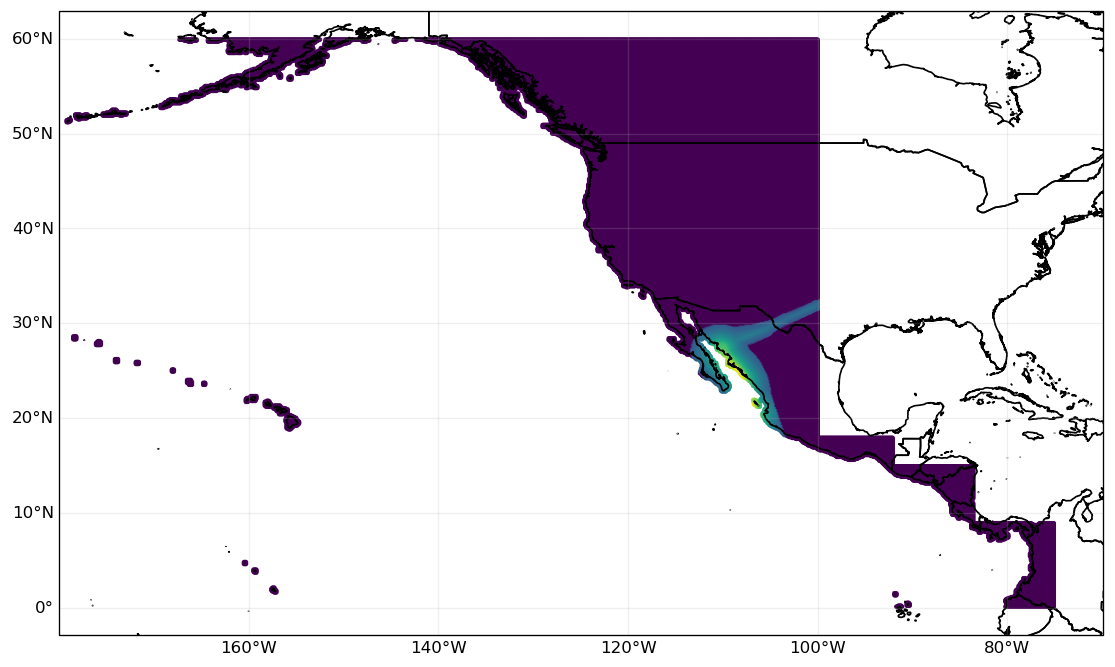

In [5]:
import shapely
hazard.centroids.region_id = shapely.vectorized.contains(
    region.shape, hazard.centroids.lon, hazard.centroids.lat) & hazard.centroids.on_land.astype(bool)
hazard_EP = hazard.select(reg_id=1)
# Plot one event as an example:
hazard_EP.centroids.plot(c=hazard_EP.intensity[31577,:].toarray().ravel(), s=3)

### Extract events that affect the region of interest
The emulator's statistics and sampling functionality doesn't use the Hazard object directly, but an aggregated version of it (a pandas `DataFrame`). From the Hazard objects, we extract those events that actually "affect" the georegion of interest and store for each the maximum intensity observed within the region (as well as date and location of occurrence):

In [6]:
from climada.hazard.emulator.stats import haz_max_events

# for this example, we regard grid cells as `affected` if they face at least 34 knots wind speeds
KNOTS_2_MS = 0.514444
MIN_WIND_MS = 34 * KNOTS_2_MS

max_events_base = haz_max_events(hazard_EP, min_thresh=MIN_WIND_MS)
max_events_base

2020-12-16 14:34:12,814 - climada.hazard.emulator.stats - INFO - Condensing 45300 hazards to 7401 max events ...


,id,name,year,month,day,lat,lon,intensity
0,1,1,1950,8,17,25.1,-112.3,42.654243
1,5,5,1950,9,3,18.7,-104.0,36.720880
2,8,8,1950,9,17,27.2,-114.0,32.730017
3,13,13,1950,11,24,17.2,-100.6,42.861889
4,17,17,1950,10,26,22.9,-106.3,47.887202
...,...,...,...,...,...,...,...,...
7396,45260,28460,2100,11,21,24.1,-107.0,29.222734
7397,45261,28461,2100,10,25,27.4,-114.2,34.721709
7398,45274,28474,2100,10,20,18.1,-102.1,89.034839
7399,45284,28484,2100,10,9,17.8,-101.5,59.966329


### Making draws from the event pool
The most basic functionality of the emulator module is then to subsample from this event pool according to a desired frequency and intensity *without taking the date of events into account at all*:

In [7]:
from climada.hazard.emulator.emulator import EventPool
event_pool = EventPool(max_events_base)
draws = event_pool.draw_realizations(nrealizations=10, freq_poisson=10, intensity_mean=30, intensity_std=5)

The result `draws` is a list of `nrealizations` subsamples from `tc_events_pool`. The number of events in each sample `DataFrame` is driven by a Poisson distribution (`lambda = 10`) and each DataFrame's mean intensity is 30±5:

In [8]:
assert len(draws) == 10
display(draws[0])
print("Number of events in each sample:", [d.shape[0] for d in draws])
print("Mean intensity of each sample:", [d['intensity'].mean() for d in draws])

,id,name,year,month,day,lat,lon,intensity
754,5285,5285,1967,6,23,18.3,-103.3,30.302091
3458,22096,5296,2023,10,8,15.7,-93.7,47.669055
2357,15416,15416,2001,8,19,22.8,-110.1,30.646163
1329,8892,8892,1979,5,6,19.2,-104.8,39.077807
4153,26512,9712,2038,8,17,31.3,-116.4,18.318382
2131,13949,13949,1996,11,6,18.6,-103.4,34.297652
89,635,635,1952,6,14,21.3,-106.5,51.698398
5106,32250,15450,2057,9,8,21.4,-106.6,37.932184
4703,29808,13008,2049,11,1,59.8,-162.9,20.645396
4844,30510,13710,2051,9,22,26.2,-112.6,26.817070


Number of events in each sample: [10, 7, 11, 7, 10, 13, 11, 16, 12, 6]
Mean intensity of each sample: [33.74041981432531, 32.36753130917463, 34.59815875000344, 31.5348526999235, 33.67298356212818, 27.126272794400833, 34.588544482580225, 32.567385754309875, 33.97376593673842, 33.712914894777875]


### Bias-corrected statistics
Now, as noted above, our database actually attaches date information to the events:

In [9]:
import datetime as dt
minyear, maxyear = [dt.datetime.fromordinal(d) for d in [hazard.date.min(), hazard.date.max()]]
print(f"The hazard event database covers the period between {minyear} and {maxyear}.")

The hazard event database covers the period between 1950-01-03 00:00:00 and 2100-12-29 00:00:00.


However, the database contains much more events per year than the underlying physics would suggest. That's why the creator of the global database provides information about frequency, from which we created the following CSV-data (see last section for more information about the data source and pre-processing steps taken):

In [10]:
import pandas as pd
frequency = pd.read_csv(os.path.join(EMULATOR_DATA_DIR, "freq_miroc_rcp26.csv"))
with pd.option_context("display.max_rows", 5):
    display(frequency)

,year,freq
0,1950,0.299428
1,1951,0.289091
...,...,...
149,2099,0.348597
150,2100,0.354156


The `freq` column encodes the relative surplus of events for each year: A `freq` value of `0.29` means that the expected number of events for a particular year is `29`, while the actual number of events in the database for that year is `100`. Depending on your data provider, it might be more or less simple to derive this kind of information for your event database.

The database might be subject to regional biases: While the whole global event database might represent global statistics of certain physical properties very well, it can still systematically under- or overestimating regionally aggregated properties. One way to "bias-correct" this kind of effect is by comparing with historical records. That's where a second event database comes in, a database of observed hazard events:

In [11]:
observed = TropCyclone()
observed.read_hdf5(os.path.join(EMULATOR_DATA_DIR, "hazard_360as_ibtracs_1950-2019.hdf5"))
observed.centroids.region_id = shapely.vectorized.contains(
    region.shape, observed.centroids.lon, observed.centroids.lat) & observed.centroids.on_land.astype(bool)
observed_EP = observed.select(reg_id=1)

2020-12-16 14:34:12,941 - climada.hazard.base - INFO - Reading /home/tovogt/code/climada_python/data/emulator/hazard_360as_ibtracs_1950-2019.hdf5


Since the quality of observed data is known to vary a lot in different world regions, we restrict our dataset to an appropriate norm period. Again we condense the hazard object to a DataFrame.

In [12]:
from climada.hazard.emulator.const import TC_BASIN_NORM_PERIOD
norm_period = TC_BASIN_NORM_PERIOD[region.tc_basin[:2]]
observed_EP = observed_EP.select(date=(f"{norm_period[0]}-01-01", f"{norm_period[1]}-12-31"))
max_events_observed = haz_max_events(observed_EP, min_thresh=MIN_WIND_MS)

2020-12-16 14:34:13,274 - climada.hazard.emulator.stats - INFO - Condensing 7335 hazards to 377 max events ...


We would now have all the data for bias correction, but we don't have to do this manually. The emulator module takes care of this.

### Initialize and calibrate the hazard emulator
The most complex part of the emulator module is the `HazardEmulator` class that automatically applies bias-correction and provides functionality to make draws according to corrected statistics. In the next section, we will see that it can even make draws according to a climate scenario.

In [13]:
from climada.hazard.emulator.emulator import HazardEmulator
em = HazardEmulator(max_events_base, max_events_observed, region, frequency, pool=event_pool)

2020-12-16 14:34:13,420 - climada.hazard.emulator.random - INFO - Results of intensity normalization by subsampling:
2020-12-16 14:34:13,421 - climada.hazard.emulator.random - INFO - - drop 35% of entries satisfying 'intensity > 37.60902402823995'
2020-12-16 14:34:13,421 - climada.hazard.emulator.random - INFO - - mean intensity of simulated events before dropping is 37.6090
2020-12-16 14:34:13,422 - climada.hazard.emulator.random - INFO - - mean intensity of simulated events after dropping is 35.4003
2020-12-16 14:34:13,422 - climada.hazard.emulator.random - INFO - - mean intensity of observed events is 34.6826


All corrections discussed above have already been applied upon initialization and aggregated in the `stats` attribute (it's mainly for internal use, so don't worry if you don't understand the meaning of all the columns):

In [14]:
em.stats

,year,eventcount,intensity_mean,intensity_std,intensity_max,eventcount_obs,intensity_mean_obs,intensity_std_obs,intensity_max_obs
0,1950,5.041561,37.560036,10.921193,56.148643,3.0,32.444994,4.193251,38.302107
1,1951,4.056249,32.092965,12.225921,61.743472,6.0,21.487378,2.879905,25.614798
2,1952,5.830183,37.488452,15.000097,60.163892,NaN,NaN,NaN,NaN
3,1953,2.185263,33.317693,9.302551,41.871618,3.0,26.853119,2.943347,30.412018
4,1954,3.123722,30.061603,9.982461,37.396814,8.0,29.232035,8.669075,47.533993
...,...,...,...,...,...,...,...,...,...
146,2096,5.641057,39.148745,12.819278,50.586874,NaN,NaN,NaN,NaN
147,2097,7.649071,35.221123,12.889677,55.557459,NaN,NaN,NaN,NaN
148,2098,4.050403,33.088812,12.990415,55.963069,NaN,NaN,NaN,NaN
149,2099,5.217263,34.029102,14.014108,52.617260,NaN,NaN,NaN,NaN


We can now draw ensembles of events that adhere to the bias-corrected statistics:

In [15]:
# the meaning of `predict_statistics` will be explained in the next section
em.predict_statistics()
draws = em.draw_realizations(10, (2030, 2050))

2020-12-16 14:34:13,440 - climada.hazard.emulator.emulator - INFO - Predicting statistics without climate index predictor...
2020-12-16 14:34:13,442 - climada.hazard.emulator.emulator - INFO - Drawing 10 realizations for period  (2030, 2050)
2030 ... 2050 ... 2050


The returned object `draws` is a `DataFrame` with each row corresponding to a storm event from the hazard pool `hazard_EP` (see above): The column `real_id` assigns one of 100 realizations to each of the events while the columns `id` and `name` are the unique ID and name used in `hazard_EP` to identify this hazard event. The column `year` indicates the year in which the event *would* occur under the hypothetical corrected statistics.

In [16]:
display(draws[:25:2])

,id,name,year,real_id
0,5002,5002,2030,0
2,28485,11685,2030,0
4,8724,8724,2030,2
6,17148,348,2030,2
8,10339,10339,2030,3
10,7026,7026,2030,3
12,27333,10533,2030,5
14,1523,1523,2030,6
16,12183,12183,2030,7
18,20406,3606,2030,8


### Draw samples according to climate scenario
The emulator can also be used to sample hypothetical events within an arbitrary time period covered by one or several climate index time series:

In [17]:
climate_indices = [pd.read_csv(os.path.join(EMULATOR_DATA_DIR, "gmt_miroc_rcp26.csv")),
                   pd.read_csv(os.path.join(EMULATOR_DATA_DIR, "esoi_miroc_rcp26.csv"))]
with pd.option_context("display.max_rows", 5):
    display(*[df for df in climate_indices])

,gmt,year,month
0,0.040892,1861,7
1,0.053463,1862,7
...,...,...,...
437,1.397416,2298,7
438,1.375225,2299,7


,esoi,year,month
0,-0.316829,1861,1
1,-0.479121,1861,2
...,...,...,...
5266,-0.569960,2299,11
5267,-0.523571,2299,12


An arbitrary number of climate indices can be provided in a list, each as a `DataFrame` with a `year` column and an additional column (in this example, `gmt` or `esoi`, respectively) containing the actual climate index data. Optionally, each climate index `DataFrame` can be at monthly resolution (like in the `esoi` example), as indicated by an additional `month` column. A constant `month` column (like in the `gmt` example above) will be discarded automatically by the emulator.

Using those climate index time series, we calibrate the emulator, i.e., we determine a statistical connection between climate indices (GMT and ENSO in this example) and `tc_events_pool`:

In [18]:
em.calibrate_statistics(climate_indices)

Now that the emulator is calibrated, we use GMT and ENSO time series to predict TC statistics under the chosen climate scenario:

In [19]:
em.predict_statistics(climate_indices)

2020-12-16 14:34:14,601 - climada.hazard.emulator.emulator - INFO - Predicting statistics with new climate index time series...


The predicted statistics are stored in the `stats_pred` attribute of the emulator:

In [20]:
em.stats_pred

,year,gmt,esoi,intensity_mean,intensity_mean_residuals,eventcount,eventcount_residuals
0,1861,0.040892,0.170012,34.803000,2.637305,4.176576,1.272837
1,1862,0.053463,-0.813848,34.038959,2.637305,4.406238,1.272837
2,1863,0.063511,1.040317,35.478856,2.637305,4.018993,1.272837
3,1864,0.061416,1.441388,35.790317,2.637305,3.935384,1.272837
4,1865,0.059797,1.129038,35.547754,2.637305,3.996921,1.272837
...,...,...,...,...,...,...,...
434,2295,1.395940,-0.726180,34.107040,2.637305,6.248324,1.272837
435,2296,1.407416,0.648489,35.174572,2.637305,5.842586,1.272837
436,2297,1.410368,0.769933,35.268883,2.637305,5.811002,1.272837
437,2298,1.397416,0.870595,35.347054,2.637305,5.761524,1.272837


Since the climate index time series covers a larger range than our hazard database (1861-2299 vs. 1950-2100), we can even predict the statistics in years that have not been covered by the hazard database.

In [21]:
draws = em.draw_realizations(10, (2110, 2130))
display(draws[:25:2])

2020-12-16 14:34:14,626 - climada.hazard.emulator.emulator - INFO - Drawing 10 realizations for period  (2110, 2130)
2110 ... 2130 ... 2130


,id,name,year,real_id
0,13973,13973,2110,0
2,24253,7453,2110,0
4,14891,14891,2110,0
6,21909,5109,2110,0
8,309,309,2110,1
10,27897,11097,2110,1
12,38751,21951,2110,1
14,31890,15090,2110,1
16,13222,13222,2110,2
18,14662,14662,2110,2


### Create sample Hazard object from draws
Using the DataFrame `draws`, we can produce a hazard object that contains the sampled events from `hazard_EP`:

In [22]:
hazard_sample = hazard_EP.select(event_names=draws['name'].tolist())

For this event to represent the sample, we need to adjust the date (and, optionally, the frequency according to the number of realizations):

In [23]:
years = [dt.datetime.fromordinal(d).year for d in hazard_sample.date]
hazard_sample.date += [dt.datetime(y_dst, 1, 1).toordinal() - dt.datetime(y, 1, 1).toordinal()
                       for y_dst, y in zip(draws['year'].values, years)]

In [24]:
dates = [dt.datetime.fromordinal(d) for d in hazard_sample.date]
display(dates[:5])
display(dates[-5:])

[datetime.datetime(2110, 7, 26, 0, 0),
 datetime.datetime(2110, 12, 11, 0, 0),
 datetime.datetime(2110, 1, 14, 0, 0),
 datetime.datetime(2110, 7, 26, 0, 0),
 datetime.datetime(2110, 8, 29, 0, 0)]

[datetime.datetime(2130, 7, 29, 0, 0),
 datetime.datetime(2130, 5, 28, 0, 0),
 datetime.datetime(2130, 6, 2, 0, 0),
 datetime.datetime(2130, 9, 13, 0, 0),
 datetime.datetime(2130, 4, 3, 0, 0)]

For the resulting `TropCyclone` object to be valid, the event names have to be unique. Since our subsampler makes draws for each year and realization indepedent of any other year and realization, events might occur in more than one year or realization. One way of dealing with this, is the following renaming step:

In [25]:
hazard_EP.event_names = [f"{row.name}-{row.year}-{row.real_id}"
                         for index, row in draws.iterrows()]
hazard_EP.check()

### About the input data used for this notebook

Since a crucial ingredient for this module is a (sufficiently large) database of hazard events, executing this tutorial notebook requires external data that is not provided with the official CLIMADA repository. The data is expected to be located in the subdirectory `data/emulator/` of the CLIMADA repository directory (called `EMULATOR_DATA_DIR` above). More precisely, these are the files used in this notebook with information about how to obtain and pre-process the data:

* **`hazard_360as_miroc_rcp26.hdf5`**: A `TropCyclone` object (stored as 700 MB hdf5-file) that represents the simulated hazard event database. It has been generated from simulated TC tracks provided by Kerry Emanuel for [ISIMIP (version 2b)](https://www.isimip.org/protocol/#isimip2b). Tracks for the period 1950-2100 according to the MIROC5 GCM simulations of the RCP 2.6 scenario have been loaded into CLIMADA using the `TCTracks.read_simulations_emanuel` functionality. The wind fields have been computed from the tracks using CLIMADA's `TropCyclone.set_from_tracks` function and a global set of centroids with 360 arc-seconds (0.1 degree) resolution onland and 1 degree resolution offshore (plotted above).

* **`hazard_360as_ibtracs_1950-2019.hdf5`**: A `TropCyclone` object (stored as 95 MB hdf5-file) that represents the observed hazard event database. It has been generated from records in the [IBTrACS database](https://www.ncdc.noaa.gov/ibtracs/) for the years 1950-2019. The tracks have been loaded into CLIMADA using the `TCTracks.read_ibtracs_netcdf` function. Then, wind fields have been computed as for the simulated tracks (see `hazard_360as_miroc_rcp26.hdf5`).

* **`freq_miroc_rcp26.csv`**: A table with `year` and `freq` column covering the years 1950-2100. The `freq` values have been obtained by dividing the `freqyear` field contained in the simulated TC tracks (see `hazard_360as_miroc_rcp26.hdf5`) by 300 (the total number of global tracks per year in the simulated TC track files).

* **`gmt_miroc_rcp26.csv`**: A table with `gmt`, `year` and `month` field (the month is constantly set to `7`). GMT stands for "Global Mean (surface) Temperature". The [CMIP5](https://pcmdi.llnl.gov/mips/cmip5/) monthly mean atmopsheric (Amon) `tas` temperature field of MIROC5 RCP 2.6 simulations covering the years 1861-2299 has been averaged globally and annually using the data processing tool [CDO](https://code.mpimet.mpg.de/projects/cdo/). The data is relative to the mean over the 500 year pre-industrial control run of the GCM and the time series has been smoothed by applying a 21-year running mean.

* **`esoi_miroc_rcp26.csv`**: A table with `esoi`, `year` and `month` field. ESOI stands for "Equatorial Southern Oscillation Index". Instructions on how to compute this index from air pressure can be found on the [ENSO Monitoring website](https://iridl.ldeo.columbia.edu/maproom/ENSO/Time_Series/Equatorial_SOI.html), hosted by Columbia University. For the air pressure input, we extracted the [CMIP5](https://pcmdi.llnl.gov/mips/cmip5/) monthly mean atmopsheric (Amon) `psl` field of MIROC5 RCP 2.6 simulations covering the years 1861-2299.